In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib import pyplot as plt
from datetime import datetime

plt.style.use("Solarize_Light2")


In [2]:
%%time

df_off = pd.read_csv("data/cleaned_data.csv")
df_off.shape


CPU times: total: 328 ms
Wall time: 330 ms


(39241, 25)

Analyse des variables : 


Analyse de la repartition des nutriscores :

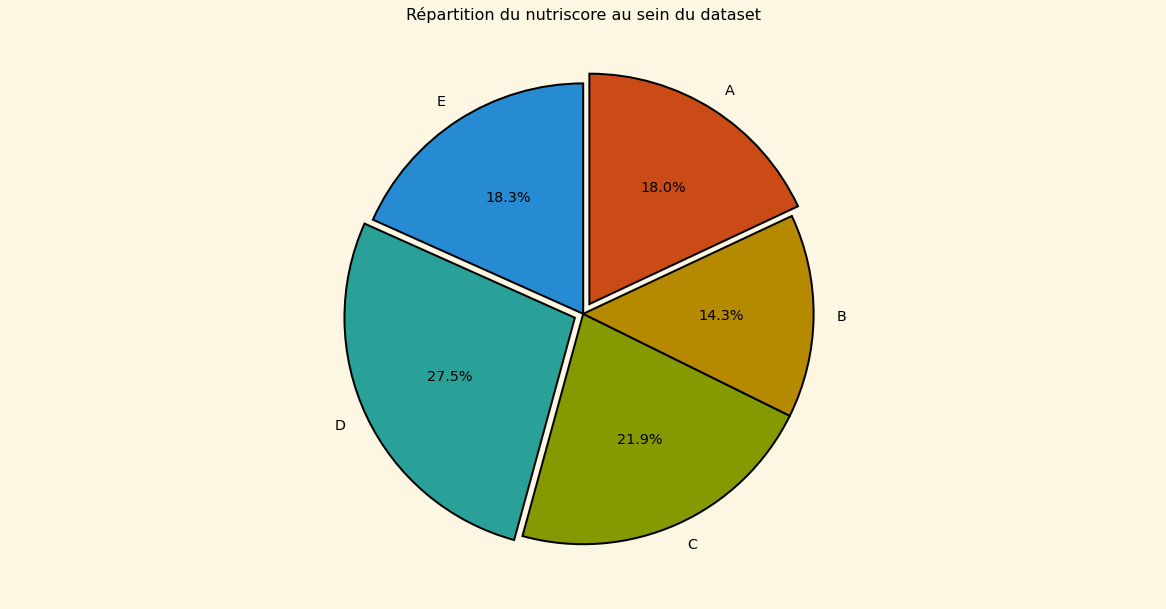

In [3]:
grades = df_off["nutrition_grade_fr"].unique()

amount = {}

for grade in grades:
        amount[grade] = df_off['nutrition_grade_fr'].value_counts()[grade]

slices = list(amount.values())
labels = [key.upper() for key in amount.keys()]

textprops = {
    "size": "x-large",
}

fig = plt.figure(figsize=(16,8))

explode = (0, 0.04, 0, 0, 0.05)
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(slices, labels=labels, startangle=90, explode=explode, textprops=textprops,
        autopct='%1.1f%%', wedgeprops={'linewidth': 2,'edgecolor': 'black'})

plt.title("Répartition du nutriscore au sein du dataset")
plt.show()



<h2><u>Analyse du graphe de repartition du nutriscore au sein du dataset :</u></h2>

- Les notes que l'ont peut considérer comme mauvaises (E, D et, pour certaines catégories, C) dominent largement le dataset
- A première vue, les propositions de produits de meilleur qualité selon le Nutriscore se montreront pertinentes. Il convient de faire une analyse du Nutriscore par categorie (PNNS groups 1 & 2) afin de vérifier cette hypothèse.
- Si cette observation globale se confirme parmi les grandes categories mises en places par le PNNS, l'intérêt et le potentiel de l'application seraient renforcés.

<hr>
Il convient d'analyser d'une part l'hypothèse émise plus haut et d'autre part la pertinence du Nutriscore comme outil de mesure qualitatif.
<hr>

<h2><u>Proportion de produits évalués dans le cas des variables "bio" et "huile de palme"</u></h2>

Lors du nettoyage du dataset, plusieurs labels parmi les labels "bio" les plus communs ont été sélectionnés et une tentative d'assertion de la présence d'huile de palme dans les produits a été effectuée.
<br>
Nous pouvons établir la proportion de ces évaluations respectives au sein de nos données. (<i>A noter que les produits dont la variable "Bio" a été évaluée, le label était présent et donc le produit est labellisé bio</i>)

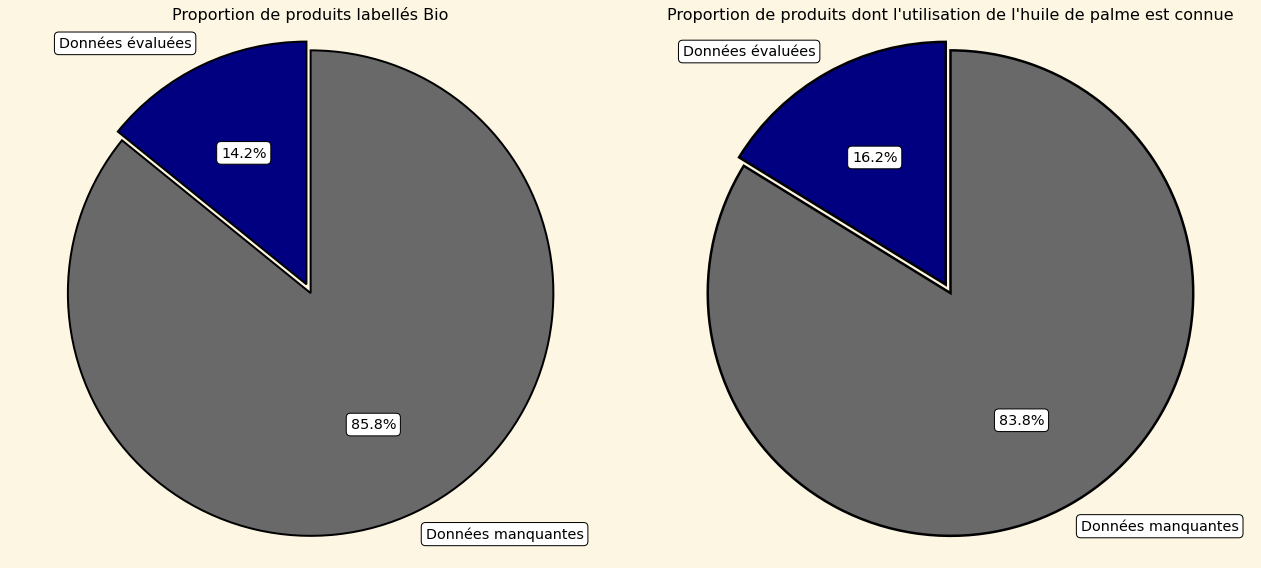

In [4]:
total_products = len(df_off)

rated_organic = df_off["organic"].notna().sum()
organic_data = [rated_organic, total_products - rated_organic]
rated_palm_oil = df_off["palm_oil"].notna().sum()
palm_oil_data = [rated_palm_oil, total_products - rated_palm_oil]

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 8))

labels = ["Données évaluées", "Données manquantes"]

bbox=dict(facecolor='white', edgecolor='black', boxstyle="round")

textprops = {
    "size": "x-large",
    "bbox": bbox,
    "backgroundcolor": "white",
    
}

colors = ["navy", "dimgrey"]

ax1.axis('equal')
ax2.axis('equal')

ax1.pie(
    organic_data, startangle=90, autopct='%1.1f%%',
    wedgeprops={'linewidth': 2,'edgecolor': 'black'},
    labels=labels, textprops=textprops, colors=colors,
    explode=[0.04, 0]
    )

ax2.pie(
    palm_oil_data, startangle=90, autopct='%1.1f%%',
    wedgeprops={'linewidth': 2.5,'edgecolor': 'black'},
    labels=labels, textprops=textprops, colors=colors,
    explode=[0.04, 0]
    )

ax1.set_title("Proportion de produits labellés Bio")
ax2.set_title("Proportion de produits dont l'utilisation de l'huile de palme est connue")

plt.tight_layout()

plt.show()


Dans les deux cas, le chiffre peut sembler faible mais, d'une part :

- Selon l’Observatoire de la distribution responsable (FCD) rapporte qu'en 2019 4.8% des produits trouvés en grande surface étaient d'origine "Bio". Les données évaluées ont toutes un label "Bio" listé dans le notebook de nettoyage.
- L'Observatoire des aliments affirme qu'un tiers des produits consommés contient de l'huile de palme. Dans le cas de l'indicateur calculé, il est évalué <b>si possible</b> si oui ou non l'huile de palme est utilisée. Le dataset est sans aucun doute incomplet et des données supplémentaires seraient requises.

> <h3>remarque sur PNNS group : </h3>

Le Programme National Nutrition Santé et les groupes formés par celui ci sont à plus large spectre que les categories.


In [5]:
print("Echantillon pnns_group_1", len(df_off["pnns_groups_1"].unique()))
print("Echantillon pnns_group_2", len(df_off["pnns_groups_2"].unique()))
print("Echantillon main_category_fr", len(df_off["main_category_fr"].unique()))
print("Echantillon categories_fr", len(df_off["categories_fr"].unique()))


Echantillon pnns_group_1 14
Echantillon pnns_group_2 40
Echantillon main_category_fr 837
Echantillon categories_fr 10575



- Les variables "main_category_fr" et "categories_fr" seront utiles à l'application en production. Elles permettront d'offrir plus précisément un meilleur candidat de remplacement au produit sélectionné.
- Les variables du PNNS sont plus restrictives, moins pertinentes dans un cas de comparaison, mais si elles sont assez peuplées elles peuvent permettre d'étudier les possibles corrélations entre le Nutriscore et la catégorie.

In [6]:

print("pnns_1_pop =", df_off["pnns_groups_1"].notna().sum())
print("pnns_2_pop = ", df_off["pnns_groups_2"].notna().sum())
print("Echantillon :", len(df_off))


pnns_1_pop = 39158
pnns_2_pop =  39241
Echantillon : 39241


<h2>Les deux groupes pnns peuvent utilisés avec précision.<h2>

- pnns_groups_1 : la représentation des produits est légèrement plus faible mais les critères sont plus restrictif, permettant un jugement d'ensemble
- pnns_groups_2 : ce groupe contient 40 groupes uniques mais couvre la totalité de notre dataset.

<h2>Représentation de la repartition des données en fonction de leur derniere data de modification :</h2>

- Les données sont au format timestamp UNIX
- Groupement par année : les timestamps sont calculés du timestamp le plus ancien au plus récent, par timestamp du premier janvier au 31 décembre de l'année

In [7]:
data_t = df_off["last_modified_t"]

oldest = datetime.fromtimestamp(data_t.min())
newest = datetime.fromtimestamp(data_t.max())

print(f"Les données s'étendent sur la periode {oldest} à {newest}")

Les données s'étendent sur la periode 2012-04-08 10:12:35 à 2017-04-21 02:53:41


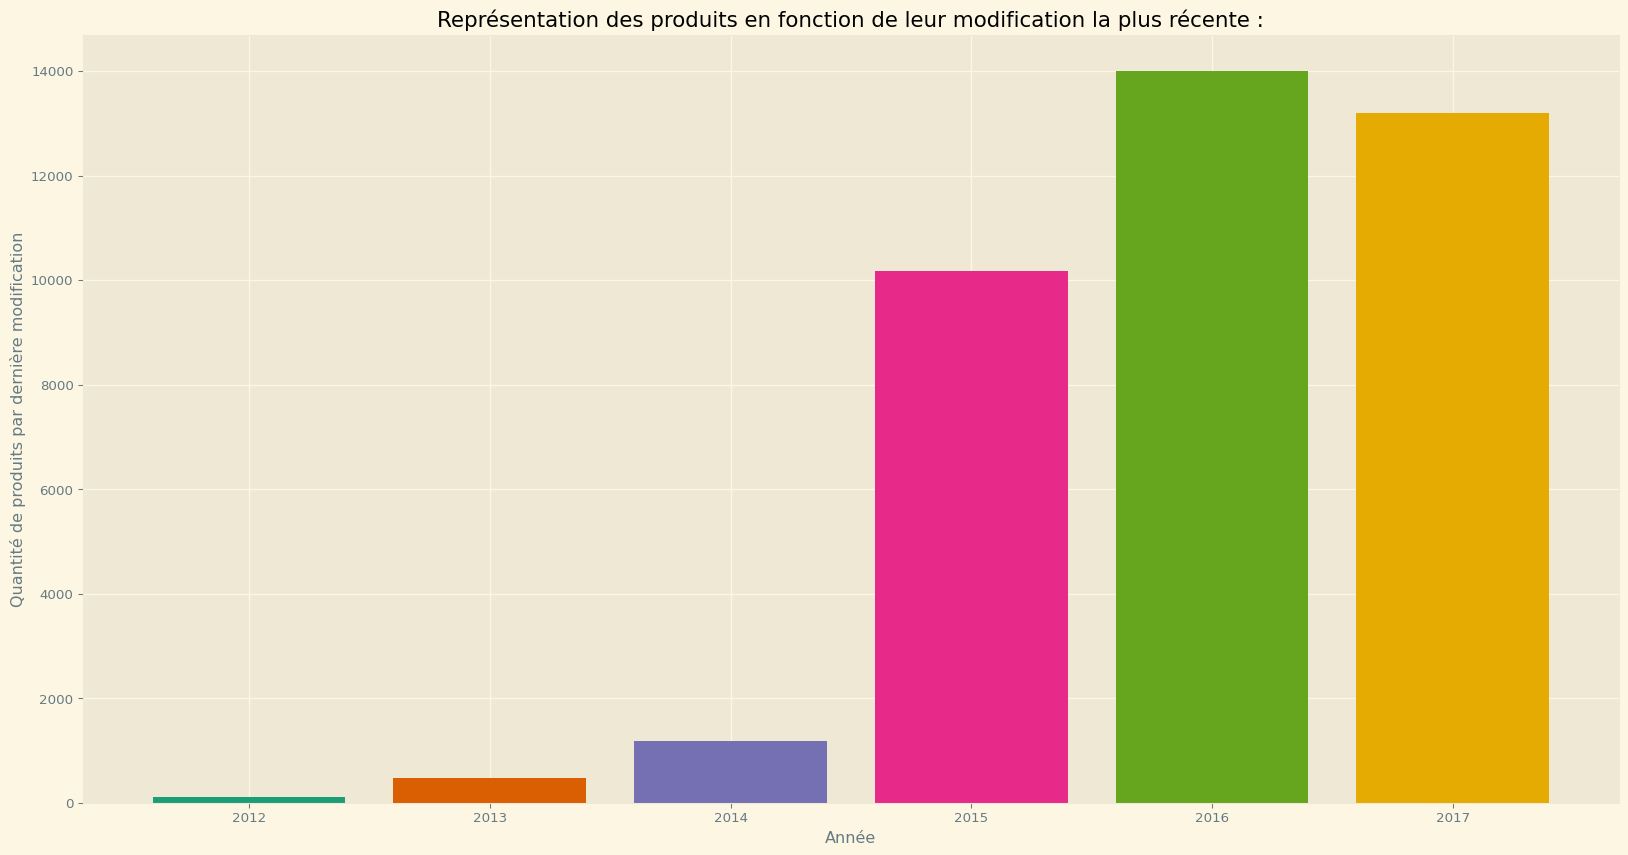

In [8]:

t_dict = {}

for year in range(2012, 2018, 1):
    jan_1=datetime(year=year, month=1, day=1).timestamp(),
    dec_31=datetime(year=year, month=12, day=31).timestamp(),
    t_dict[year] = len(data_t[(data_t > jan_1) & (data_t < dec_31)])


used_cmap = plt.get_cmap("Dark2")

fig = plt.figure(figsize=(16, 8), dpi=96)
ax = fig.add_axes([0,0,1,1])

ax.bar(t_dict.keys(), t_dict.values(), color=used_cmap.colors)

ax.set_ylabel("Quantité de produits par dernière modification")
ax.set_xlabel("Année")

title = "Représentation des produits en fonction de leur modification la plus récente :"

ax.set_title(title)
plt.show()


Par rapport à la donnée la plus récente, les autres produits ont été majoritairement mis à jour, pour la plus grande partie, 2 ans maximum avant le produit le plus récent. On peut donc considérer les données comme relativement à jour :

- Le Nutriscore a été proposé en 2014 et adopté en 2016
- Il semblerait qu'Open Food Facts ait proposé, avant son application, un système similaire <a href="https://fr.openfoodfacts.org/discover" target="blank">sur leur blog</a>
- Le Programme National Nutrition Santé a été établi en 2001 et prolongé depuis, les données peuvent donc être associées


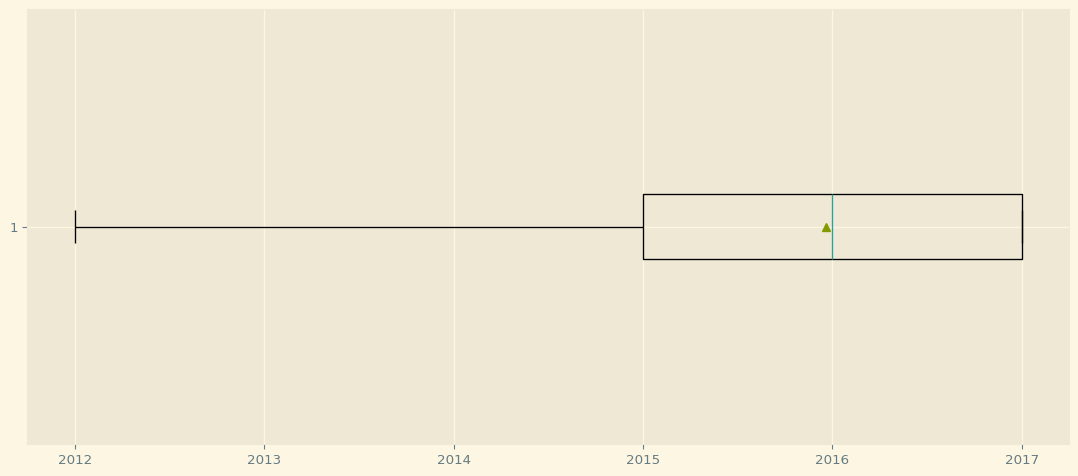

In [9]:
plt.figure(figsize=(14, 6), dpi=96)
plt.boxplot([datetime.fromtimestamp(ts).year for ts in data_t], vert=0, showmeans=True, showfliers=True)
plt.show()


Ce boxplot confirme que la très grande majorité (dès le premier quartile) des données ont été mises à jour post 2015, la notion de Nutriscore étant apparue en 2014, cela peut impliquer que, pour la très large majorité du dataset, le Nutriscore ait été ajouté après sa définition. Les valeurs anterieures à 2014 doivent avoir été calculées par le site, ou obtenues d'une autre manière (fusion des duplicatas avant publication du dataset, erreur de mise à jour de la variable "last_modified_t" (rare mais présente dans le dataset original) etc.)

scatterplot bad stuff/ns

- Le Nutriscore pour 100g est plus pertinent dans ce cas : les produits ne sont pas notés par 5 lettres mais par un nombre entre –15 et +40 (<a href="https://quoidansmonassiette.fr/etiquetage-nutritionnel-nutri-score-5-c-vainqueur-de-la-guerre-des-logos-nutritionnels/">source</a>) , rouge (E) est considéré avoir un score au delà de 17
- Il ne serait pas pertinent de traiter les produits indépendamment de leurs catégories : selon <a href="mangerbouger.fr">mangerbouger.fr</a> ↓
    > A retenir : Tout dépend du produit. Pour les yaourts qui peuvent être notés A, B ou C, le Nutri-Score C, est le moins bon score possible. Pour les huiles, qui peuvent être notées C, D ou E, le Nutri-Score C, est le meilleur score possible.

In [10]:
pnns_1 = list(df_off["pnns_groups_1"].unique())

for group in pnns_1:
    print(group, "- nombre de lignes : ", len(df_off[df_off["pnns_groups_1"] == group]))

Beverages - nombre de lignes :  3885
Sugary snacks - nombre de lignes :  6260
Salty snacks - nombre de lignes :  1607
Fruits and vegetables - nombre de lignes :  2479
unknown - nombre de lignes :  3854
Fat and sauces - nombre de lignes :  2520
Cereals and potatoes - nombre de lignes :  4494
Composite foods - nombre de lignes :  4559
fruits-and-vegetables - nombre de lignes :  383
Milk and dairy products - nombre de lignes :  4543
nan - nombre de lignes :  0
Fish Meat Eggs - nombre de lignes :  4243
sugary-snacks - nombre de lignes :  330
cereals-and-potatoes - nombre de lignes :  1


<h4>Choix de 4 valeurs :</h4>

- Salty snacks
- Composite foods
- Sugary snacks (capitalized)
- Beverages


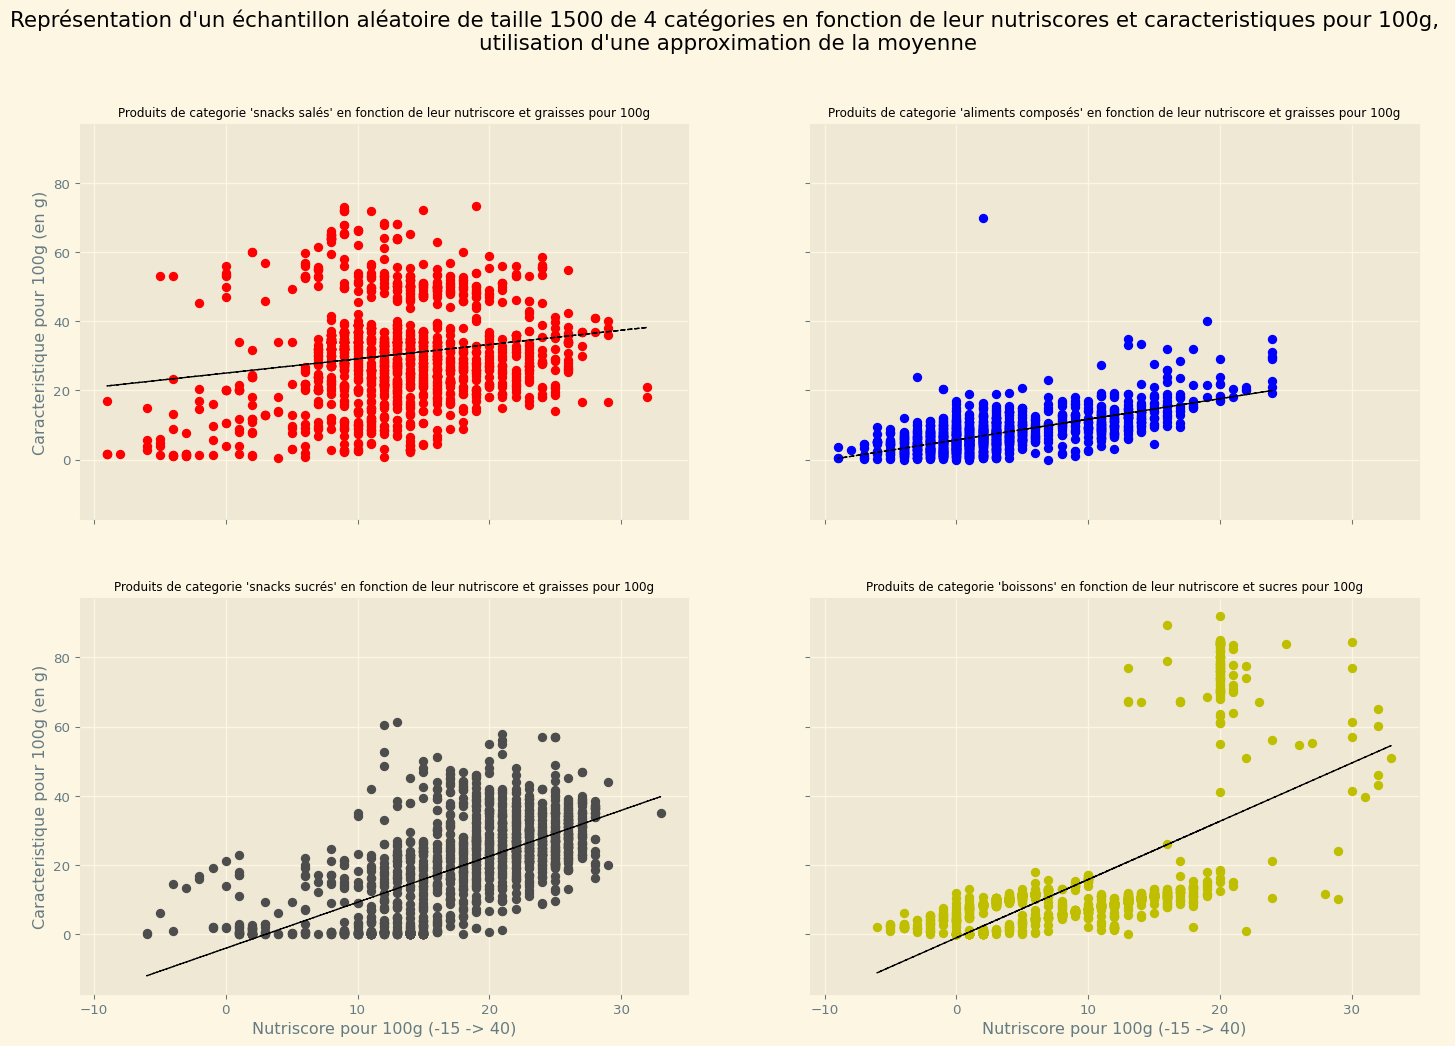

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(18, 12),
    dpi=96,
    sharex=True,
    sharey=True
)


salty_data = df_off[df_off["pnns_groups_1"] == "Salty snacks"][["nutrition-score-fr_100g", "fat_100g"]]
salty_data = salty_data[salty_data["fat_100g"].notna()]
salty_data = salty_data.sample(n=1500)

composite_data = df_off[df_off["pnns_groups_1"] == "Composite foods"][["nutrition-score-fr_100g", "fat_100g"]]
composite_data = composite_data[composite_data["fat_100g"].notna()]
composite_data = composite_data.sample(n=1500)

sugary_data = df_off[df_off["pnns_groups_1"] == "Sugary snacks"][["nutrition-score-fr_100g", "fat_100g"]]
sugary_data = sugary_data[sugary_data["fat_100g"].notna()]
sugary_data = sugary_data.sample(n=1500)

beverages_data = df_off[df_off["pnns_groups_1"] == "Beverages"][["nutrition-score-fr_100g", "sugars_100g"]]
beverages_data = beverages_data[beverages_data["sugars_100g"].notna()]
beverages_data = beverages_data.sample(n=1500)


ax1.scatter(salty_data["nutrition-score-fr_100g"], salty_data["fat_100g"], color="r")
z = np.polyfit(x=(salty_data["nutrition-score-fr_100g"]),y=salty_data["fat_100g"], deg=1)
p = np.poly1d(z)
ax1.plot((salty_data["nutrition-score-fr_100g"]), p(list(salty_data["nutrition-score-fr_100g"])), "k--", linewidth=1.0)

ax2.scatter(composite_data["nutrition-score-fr_100g"], composite_data["fat_100g"], color="b")
z2 = np.polyfit(x=(composite_data["nutrition-score-fr_100g"]),y=composite_data["fat_100g"], deg=1)
p2 = np.poly1d(z2)
ax2.plot((composite_data["nutrition-score-fr_100g"]), p2(list(composite_data["nutrition-score-fr_100g"])), "k--", linewidth=1.0)

ax3.scatter(sugary_data["nutrition-score-fr_100g"], sugary_data["fat_100g"], color="0.3")
z3 = np.polyfit(x=(sugary_data["nutrition-score-fr_100g"]),y=sugary_data["fat_100g"], deg=1)
p3 = np.poly1d(z3)
ax3.plot((sugary_data["nutrition-score-fr_100g"]), p3(list(sugary_data["nutrition-score-fr_100g"])), "k--", linewidth=1.0)

ax4.scatter(beverages_data["nutrition-score-fr_100g"], beverages_data["sugars_100g"], color="y")
z4 = np.polyfit(x=(beverages_data["nutrition-score-fr_100g"]),y=beverages_data["sugars_100g"], deg=1)
p4 = np.poly1d(z4)
ax4.plot((beverages_data["nutrition-score-fr_100g"]), p4(list(beverages_data["nutrition-score-fr_100g"])), "k--", linewidth=1.0)

# - Salty snacks=ax1 Composite foods=ax2 Sugary snacks=ax3 Beverages=ax4

###
#Titles and labels
ax1.set_title("Produits de categorie 'snacks salés' en fonction de leur nutriscore et graisses pour 100g", size=9)
ax2.set_title("Produits de categorie 'aliments composés' en fonction de leur nutriscore et graisses pour 100g", size=9)
ax3.set_title("Produits de categorie 'snacks sucrés' en fonction de leur nutriscore et graisses pour 100g", size=9)
ax4.set_title("Produits de categorie 'boissons' en fonction de leur nutriscore et sucres pour 100g", size=9)
figure_title = "Représentation d'un échantillon aléatoire de taille 1500 de\
 4 catégories en fonction de leur nutriscores et caracteristiques pour 100g\
, \nutilisation d'une approximation de la moyenne"
fig.suptitle(figure_title, fontsize=16)
ax3.set_xlabel("Nutriscore pour 100g (-15 -> 40)")
ax4.set_xlabel("Nutriscore pour 100g (-15 -> 40)")
ax1.set_ylabel("Caracteristique pour 100g (en g)")
ax3.set_ylabel("Caracteristique pour 100g (en g)")
#
###

# plt.savefig("quad_scatter.png")
plt.show()


L'analyse de ces deux variables (Nutriscore pour 100g et caracteristiques que l'ont peut qualifier de mauvaises pour la santé en forte quantité) révèlent une corrélation entre le Nutriscore et ces features.
Meme au sein d'un échantillon relativement faible (100 produits), la tendance montre que le Nutriscore est négativement affecté par des features comme la graisse et le sucre.

Le Nutriscore est également impacté par des features considérées comme positives telles que les fruits & legumes, les fibres et la teneur en protéine : <a href="https://www.health.belgium.be/sites/default/files/uploads/fields/fpshealth_theme_file/2019_faq_fr_v35_ph.pdf">source</a>. Cela explique la présence de nombreux outliers : seul un facteur par produit a été exploré, hors le Nutriscore en prend au moins 5 autres en compte.


- Les produits bios sont ils plus sains ?
- Ceux contenant de l'huile de palme sont ils moins sains ?

In [12]:
df_off.columns

Index(['last_modified_t', 'pnns_groups_1', 'categories_fr', 'main_category_fr',
       'url', 'product_name', 'code', 'brands', 'nutrition_grade_fr',
       'labels_fr', 'image_url', 'stores', 'pnns_groups_2', 'allergens',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'nutrition-score-fr_100g', 'organic', 'palm_oil'],
      dtype='object')

In [13]:
data_org_pal = df_off[["nutrition-score-fr_100g", "organic", "palm_oil"]]
data_org_pal.dropna(subset=["nutrition-score-fr_100g"])
data_org_pal = data_org_pal.fillna(False)


<h2>Etude de la possible implication de l'huile de palme et du caractère 'bio' d'un produit sur son Nutriscore</h2>

- <b>A noter :</b>
    - Les données concernant l'huile de palme ont été récupérées en cherchant sa présence dans le dataset original. Il est entèrement possible et fort probable qu'une partie des produits ait échappé à ce scan.
    - Le caractère bio d'un produit a été déterminé par ses labels, parmi la liste labels bio les plus populaires selon Open Food Facts. Il est possible que certains produits soient qualifiés de bio mais n'aient pas été labellisés comme tels
    - Nous considérerons les données manquantes comme fausses. La pertinence dans le cas du bio est probablement forte (c.f. représentation de la quantité de produits bios dans le dataset), mais l'huile de palme est probablement sous représentée

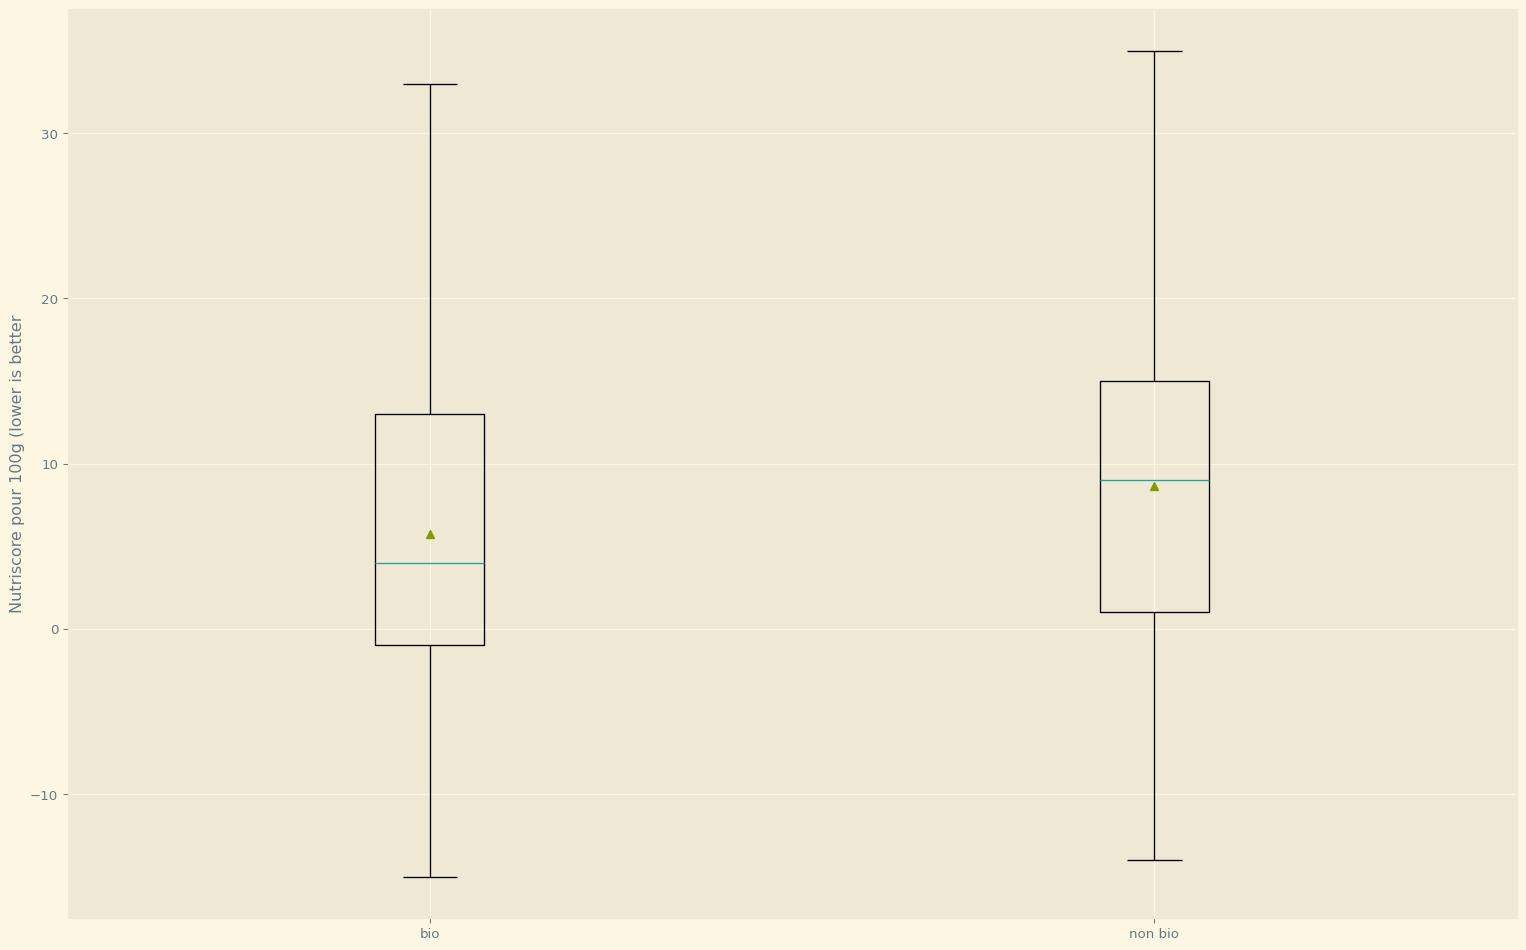

In [14]:
fig, ax1 = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(16, 10),
    dpi=96,
    sharex=True,
    sharey=True
)

data_org = data_org_pal[data_org_pal["organic"]][["nutrition-score-fr_100g", "organic"]]
data_org_t = data_org_pal[data_org_pal["organic"] == True][["nutrition-score-fr_100g"]]
data_org_f = data_org_pal[data_org_pal["organic"] == False][["nutrition-score-fr_100g"]]
data_org_list = [data_org_t["nutrition-score-fr_100g"], data_org_f["nutrition-score-fr_100g"]]

ax1.boxplot(data_org_list, showfliers=True, showbox=True, showmeans=True, labels=["bio", "non bio"])
ax1.set_ylabel("Nutriscore pour 100g (lower is better")

data_palm_pos = data_org_pal[data_org_pal["palm_oil"] == True][["nutrition-score-fr_100g", "palm_oil"]]
data_palm_undetected = data_org_pal[data_org_pal["palm_oil"].isna()][["nutrition-score-fr_100g", "palm_oil"]]

plt.tight_layout()
plt.show()


In [15]:
hashes = "\n###############################"
print("General : \n", data_org_pal[["organic", "nutrition-score-fr_100g"]].describe(), hashes)
print("Bio : \n", data_org_pal[data_org_pal["organic"] == True].describe(), hashes)
print("Non Bio : \n", data_org_pal[data_org_pal["organic"] == False].describe(), hashes)


General : 
        nutrition-score-fr_100g
count             39241.000000
mean                  8.227950
std                   8.971378
min                 -15.000000
25%                   1.000000
50%                   8.000000
75%                  15.000000
max                  35.000000 
###############################
Bio : 
        nutrition-score-fr_100g
count              5559.000000
mean                  5.714157
std                   8.948202
min                 -15.000000
25%                  -1.000000
50%                   4.000000
75%                  13.000000
max                  33.000000 
###############################
Non Bio : 
        nutrition-score-fr_100g
count             33682.000000
mean                  8.642836
std                   8.907382
min                 -14.000000
25%                   1.000000
50%                   9.000000
75%                  15.000000
max                  35.000000 
###############################


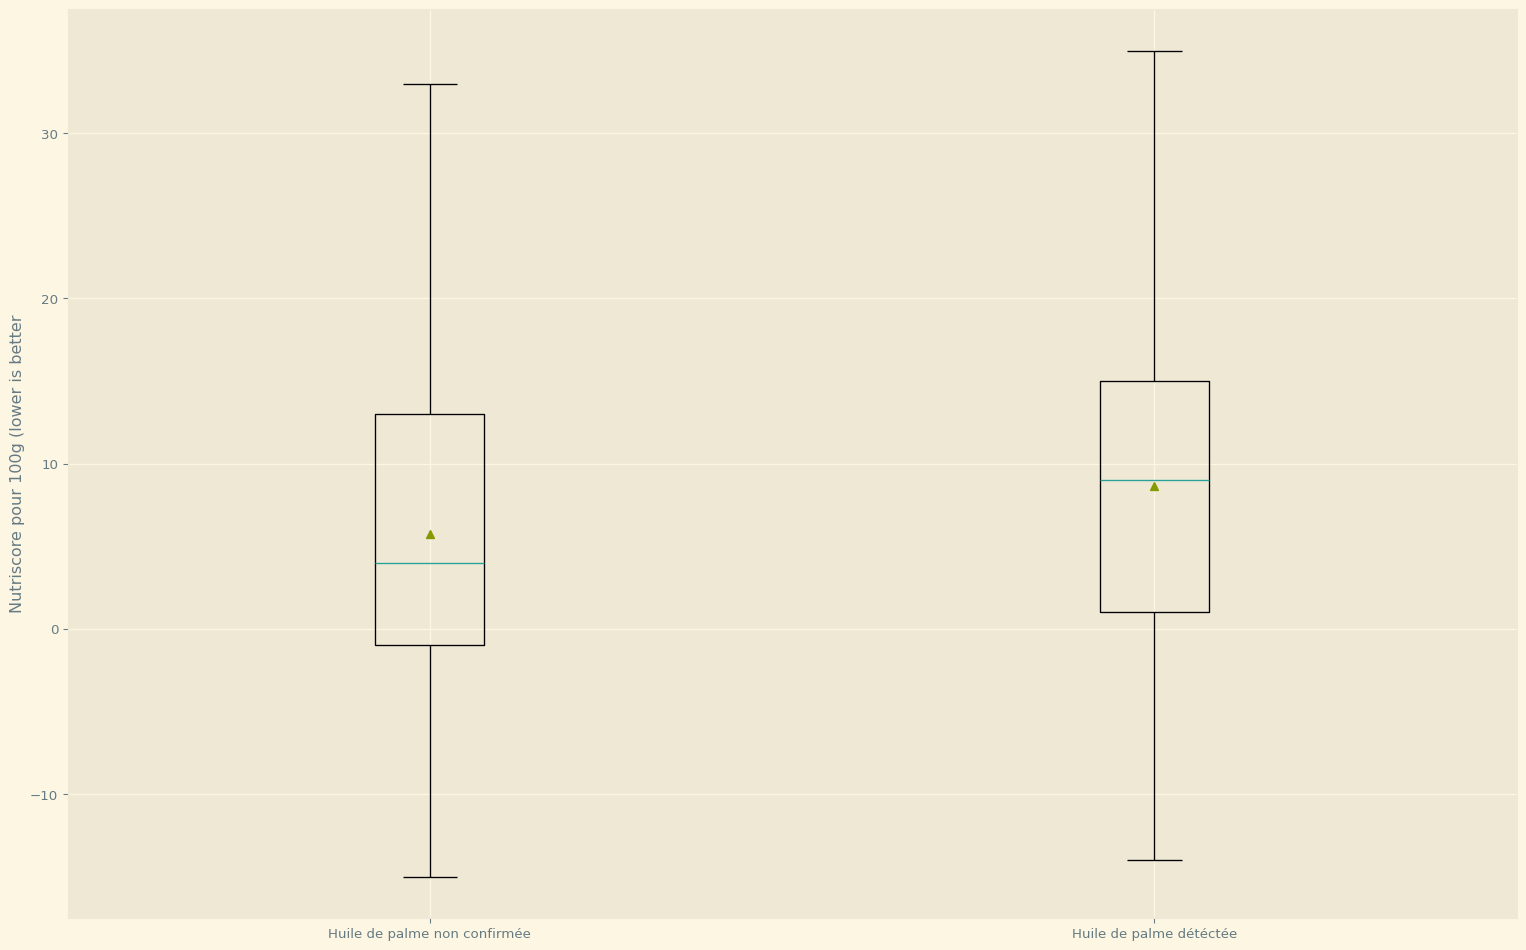

In [16]:
fig, ax1 = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(16, 10),
    dpi=96,
    sharex=True,
    sharey=True
)

data_palm = data_org_pal[data_org_pal["palm_oil"]][["nutrition-score-fr_100g", "palm_oil"]]
data_palm_t = data_org_pal[data_org_pal["palm_oil"] == True][["nutrition-score-fr_100g"]]
data_palm_f = data_org_pal[data_org_pal["palm_oil"] == False][["nutrition-score-fr_100g"]]
data_palm_list = [data_palm_f["nutrition-score-fr_100g"], data_palm_t["nutrition-score-fr_100g"]]

ax1.boxplot(data_org_list, showfliers=True, showbox=True, showmeans=True, labels=["Huile de palme non confirmée", "Huile de palme détéctée"])
ax1.set_ylabel("Nutriscore pour 100g (lower is better")

data_palm_pos = data_org_pal[data_org_pal["palm_oil"] == True][["nutrition-score-fr_100g", "palm_oil"]]
data_palm_undetected = data_org_pal[data_org_pal["palm_oil"].isna()][["nutrition-score-fr_100g", "palm_oil"]]

plt.tight_layout()
plt.show()


In [17]:
hashes = "\n###############################"
print("General : \n", data_org_pal[["palm_oil", "nutrition-score-fr_100g"]].describe(), hashes)
print("Avec huile de palme : \n", data_org_pal[data_org_pal["palm_oil"] == True].describe(), hashes)
print("Sans huile de palme : \n", data_org_pal[data_org_pal["palm_oil"] == False].describe(), hashes)


General : 
        nutrition-score-fr_100g
count             39241.000000
mean                  8.227950
std                   8.971378
min                 -15.000000
25%                   1.000000
50%                   8.000000
75%                  15.000000
max                  35.000000 
###############################
Avec huile de palme : 
        nutrition-score-fr_100g
count              6363.000000
mean                 13.151972
std                   8.206737
min                 -11.000000
25%                   7.000000
50%                  14.000000
75%                  19.000000
max                  35.000000 
###############################
Sans huile de palme : 
        nutrition-score-fr_100g
count             32878.000000
mean                  7.274986
std                   8.799381
min                 -15.000000
25%                   0.000000
50%                   6.000000
75%                  14.000000
max                  35.000000 
###############################


## Utilisation de l'ANOVA pour tenter de rejeter les hypothèses nulles :

- Hb0 : Le caractère bio d'un produit n'influence pas positivement son nutriscore
- Hp0 : La présence d'huile de palme n'influence pas négativement le nutriscore d'un produit

In [29]:
stats.f_oneway(data_org_t, data_org_f.sample(len(data_org_t)))

F_onewayResult(statistic=array([269.82391447]), pvalue=array([6.28481857e-60]))

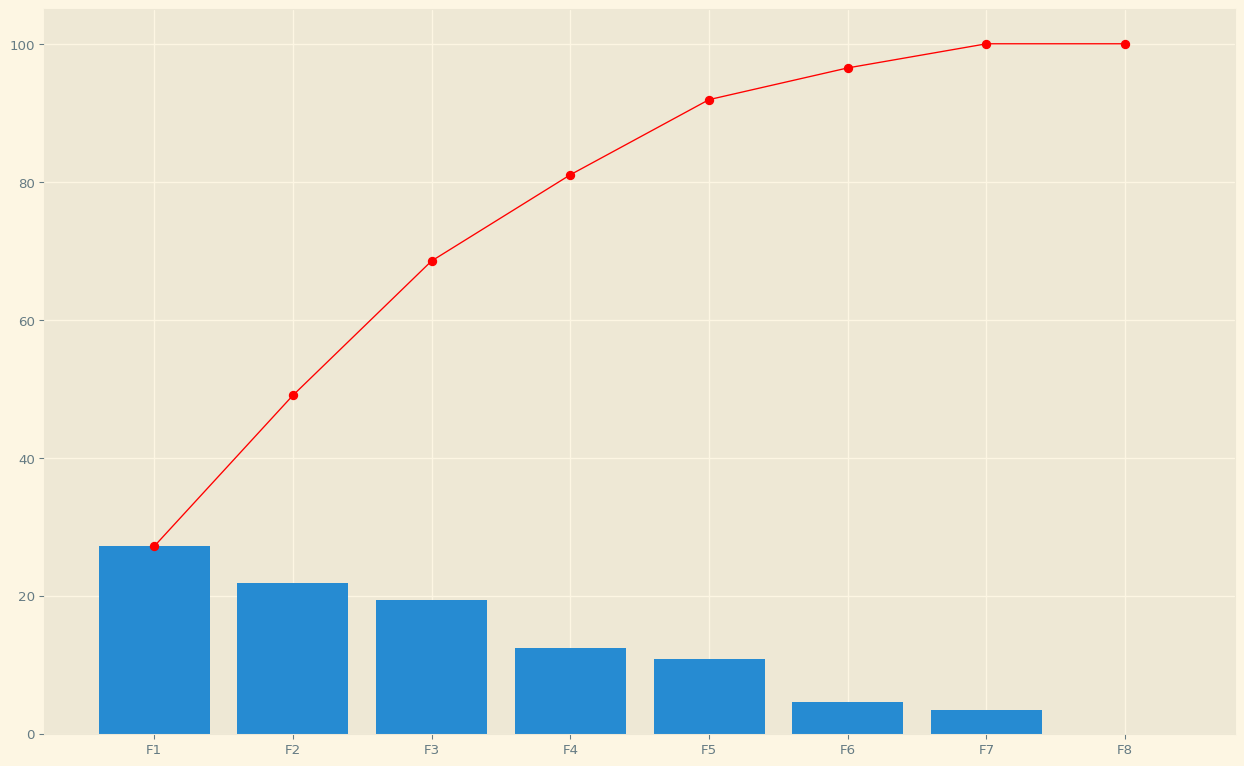

In [40]:
columns_pca = [col for col in df_off.columns if col.endswith("100g") and not col.startswith("nutri")]
data_pca = df_off[columns_pca]

data_pca = data_pca.fillna(data_pca.mean())

scaled_data = preprocessing.scale(data_pca)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
percentage_variation = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

labels = ["F" + str(c) for c in range (1, len(percentage_variation) + 1)]
x_bars = np.arange(1, len(percentage_variation) + 1, 1)

total_percentage = 0
cummulative_percentage = np.cumsum(percentage_variation)

fig, ax1 = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(16, 10),
    dpi=96,
)

ax1.bar(x=x_bars, height=percentage_variation, hue=)

ax1.set_xticks(range(1, len(labels) +1, 1))
ax1.set_xticklabels(labels)
ax1.plot(ax1.get_xticks(), cummulative_percentage, marker="o", color="r", linewidth=1)

plt.show()


In [33]:
contribution_scores = pd.Series(pca.components_[0], index=columns_pca)
sorted_contribution_scores = contribution_scores.abs().sort_values(ascending=False)
sorted_contribution_scores


salt_100g             0.587656
sodium_100g           0.587655
sugars_100g           0.329786
carbohydrates_100g    0.308211
proteins_100g         0.260898
fat_100g              0.152107
saturated-fat_100g    0.119838
energy_100g           0.001976
dtype: float64